> Alon Arbel - 205730849

> Gev Keren - 315719906

In [31]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
from copy import deepcopy
from scipy import signal, ndimage
%matplotlib inline

# Question 1 - Convolution, Fourier transform and linear systems

## Section A - DFT “Free Willy”

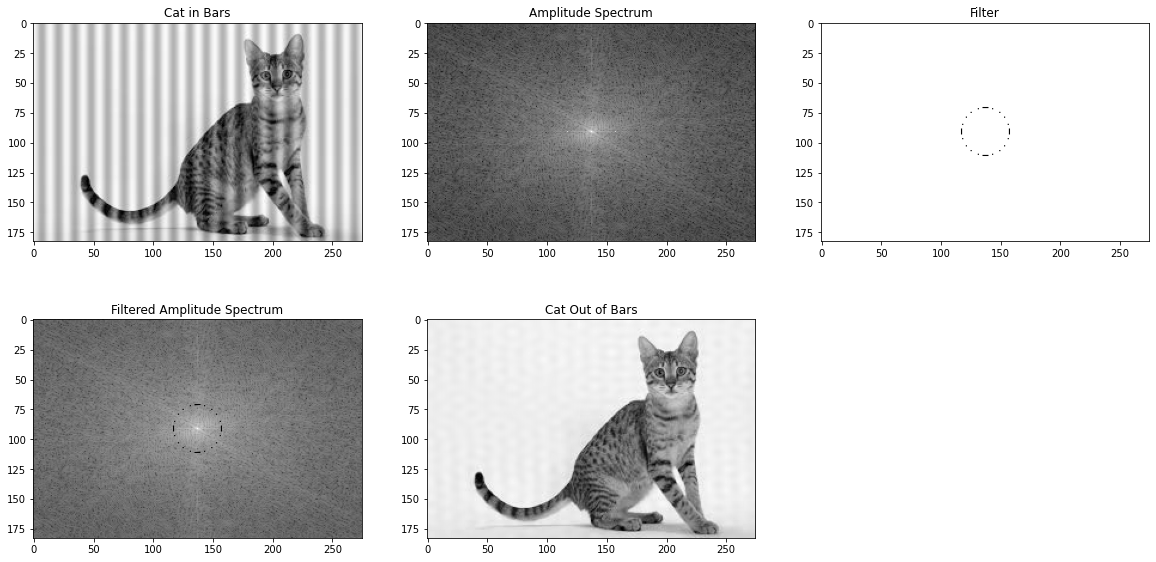

In [32]:
cat_bars = cv2.imread('cat_bars.png',0) # Reads the original grayscale image
# print(cat_bars)
#======= Replace with code to get the cat out of the bars
#Computes the image's 2D DFT
img_fft = np.fft.fft2(cat_bars)
#Shifts the zero-frequency component to the center of the spectrum
fshift = np.fft.fftshift(img_fft)

#Computing the amplitude spectrum
amplitude = 20 * np.log(np.abs(fshift) + 1)
filter = np.ones_like(cat_bars)

rows, cols = cat_bars.shape
center_row, center_col = rows // 2, cols // 2

outer_radius = 20.1  # Change this to adjust the filter strength
inner_radius = 19.9

for i in range(rows):
  for j in range(cols):
      distance_from_center = np.sqrt((i - center_row)**2 + (j - center_col)**2)
      if distance_from_center < outer_radius:
          filter[i][j] = 0
      if distance_from_center < inner_radius:
          filter[i][j] = 1
fshift *= filter

#np.fft.ifftshift inverts np.fft.fftshift
#Then np.fft.ifft2 computes the 2D inverse DFT 
img_ifft = np.fft.ifft2(np.fft.ifftshift(fshift))


amplitude_filtered = 20 * np.log(np.abs(fshift) + 1) # The amplitude spectrum after the filtering.

cat_out_of_bars = np.abs(img_ifft) # Replace with code to get the cat out of bars (the filtered image)

#========

# Showing the 5 plots requested in this section
fig, axes = plt.subplots(2,3, figsize=(20, 10))
fig.delaxes(axes[1,2])
for img, ax, title in zip([cat_bars, amplitude, filter, amplitude_filtered, cat_out_of_bars],
                          chain.from_iterable(axes), 
                          ["Cat in Bars", "Amplitude Spectrum", "Filter", "Filtered Amplitude Spectrum", "Cat Out of Bars"]):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)

Our reconstruction is not perfect. this is becuase we filtered all parts of the picture with the wanted frequencies. Those frequencies might be found in other parts of the picture as well, and will be filtered from there as well. That may cause in an imperfect reconstruction.

**Section B:**
> these are calculations to check our answers which were calculating by hand.




In [33]:
# Showing calculations
G = np.array([[0.5, 1, 0.5],
             [1  , 6, 1  ],
             [0.5, 1, 0.5]])

F = np.array([[-0.5, -1, -0.5],
             [-1  , 6 , -1  ],
             [-0.5, -1, -0.5]])

I = np.array([[0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,1,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0]])


IcG = signal.convolve(I, G, mode='same', method='auto')
# print(IcG)
# print()

FcIcG = signal.convolve(IcG, F, mode='same', method='auto')
# print(FcIcG)
# print()

H = np.array([[-0.25, -1, -1.5, -1, -0.25],
              [-1   , -2,  -2 , -2,  -1  ],
              [-1.5 , -2,  31 , -2, -1.5 ],
              [-1   , -2,  -2 , -2,  -1  ],
              [-0.25, -1, -1.5, -1, -0.25]])

IcH = signal.convolve(I, H, mode='same', method='auto')
# print(IcH)
# print()

# Question 2 - Edge detection

## Section B

In [34]:
def max_eight_environment(LoG, i, j):
  if i > 0 and i < len(LoG)-1 and j > 0 and j < len(LoG)-1:
    return max(LoG[i-1,j-1], LoG[i-1,j], LoG[i-1,j+1], LoG[i,j-1], LoG[i,j+1], LoG[i+1,j-1], LoG[i+1,j], LoG[i+1,j+1])

  elif i > 0 and i < len(LoG)-1 and j > 0 and j == len(LoG)-1:
    return max(LoG[i-1,j-1], LoG[i-1,j], LoG[i,j-1], LoG[i+1,j-1], LoG[i+1,j])

  elif i > 0 and i < len(LoG)-1 and j == 0 and j < len(LoG)-1:
    return max(LoG[i-1,j], LoG[i-1,j+1], LoG[i,j+1], LoG[i+1,j], LoG[i+1,j+1])

  elif i > 0 and i == len(LoG)-1 and j > 0 and j < len(LoG)-1:
    return max(LoG[i-1,j-1], LoG[i-1,j], LoG[i-1,j+1], LoG[i,j-1], LoG[i,j+1])

  elif i > 0 and i == len(LoG)-1 and j == 0 and j < len(LoG)-1:
    return max(LoG[i-1,j-1], LoG[i-1,j], LoG[i-1,j+1], LoG[i,j-1], LoG[i,j+1])

  elif i > 0 and i == len(LoG)-1 and j > 0 and j == len(LoG)-1:
    return max(LoG[i-1,j-1], LoG[i-1,j], LoG[i,j-1])

  elif i == 0 and i < len(LoG)-1 and j > 0 and j < len(LoG)-1:
    return max(LoG[i,j-1], LoG[i,j+1], LoG[i+1,j-1], LoG[i+1,j], LoG[i+1,j+1])

  elif i == 0 and i < len(LoG)-1 and j == 0 and j < len(LoG)-1:
    return max(LoG[i,j+1], LoG[i+1,j], LoG[i+1,j+1])

  elif i == 0 and i < len(LoG)-1 and j > 0 and j == len(LoG)-1:
    return max(LoG[i,j-1], LoG[i+1,j-1], LoG[i+1,j])

def min_eight_environment(LoG, i, j):
  if i > 0 and i < len(LoG)-1 and j > 0 and j < len(LoG)-1:
    return min(LoG[i-1,j-1], LoG[i-1,j], LoG[i-1,j+1], LoG[i,j-1], LoG[i,j+1], LoG[i+1,j-1], LoG[i+1,j], LoG[i+1,j+1])

  elif i > 0 and i < len(LoG)-1 and j > 0 and j == len(LoG)-1:
    return min(LoG[i-1,j-1], LoG[i-1,j], LoG[i,j-1], LoG[i+1,j-1], LoG[i+1,j])

  elif i > 0 and i < len(LoG)-1 and j == 0 and j < len(LoG)-1:
    return min(LoG[i-1,j], LoG[i-1,j+1], LoG[i,j+1], LoG[i+1,j], LoG[i+1,j+1])

  elif i > 0 and i == len(LoG)-1 and j > 0 and j < len(LoG)-1:
    return min(LoG[i-1,j-1], LoG[i-1,j], LoG[i-1,j+1], LoG[i,j-1], LoG[i,j+1])

  elif i > 0 and i == len(LoG)-1 and j == 0 and j < len(LoG)-1:
    return min(LoG[i-1,j-1], LoG[i-1,j], LoG[i-1,j+1], LoG[i,j-1], LoG[i,j+1])

  elif i > 0 and i == len(LoG)-1 and j > 0 and j == len(LoG)-1:
    return min(LoG[i-1,j-1], LoG[i-1,j], LoG[i,j-1])

  elif i == 0 and i < len(LoG)-1 and j > 0 and j < len(LoG)-1:
    return min(LoG[i,j-1], LoG[i,j+1], LoG[i+1,j-1], LoG[i+1,j], LoG[i+1,j+1])

  elif i == 0 and i < len(LoG)-1 and j == 0 and j < len(LoG)-1:
    return min(LoG[i,j+1], LoG[i+1,j], LoG[i+1,j+1])

  elif i == 0 and i < len(LoG)-1 and j > 0 and j == len(LoG)-1:
    return min(LoG[i,j-1], LoG[i+1,j-1], LoG[i+1,j])


def zero_crossing(LoG, a, b):
    """
    This function gets as input the LoG and calculates the zero crossings. 
    The output is a binary matrix with 1 in all the zero crossing pixels
    and 0 otherwise.
    """
    binMatrix = np.zeros_like(LoG)
    for i in range(len(LoG)):
      for j in range(len(LoG[i])):
        if (LoG[i][j] > a and min_eight_environment(LoG, i, j) < b) or (LoG[i][j] < b and max_eight_environment(LoG, i, j) > a):
          binMatrix[i][j] = 1
    return binMatrix

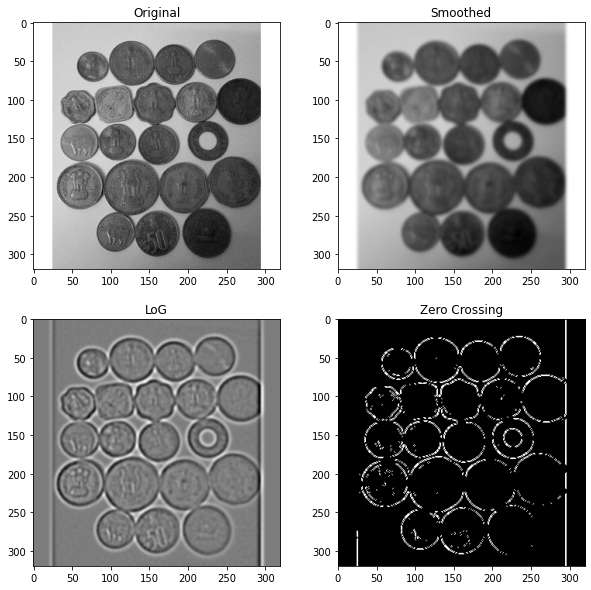

In [35]:
# Reads the original image in grayscale, and sets the image range to be 0-1 (instead of 0-255)
coins = cv2.imread('coins.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255 #'coins': The original image in grayscale.

## Implementation of LoG as shown in tutorial #6
laplacian_kernel = np.array([
    [0, -1,  0],
    [-1, 4, -1],
    [0, -1,  0],
])
# 'smoothed': The smoothed image (i.e., the image after applying the Gaussian smoothing).
smoothed = cv2.GaussianBlur(coins, (11, 11) ,0) # You may change the 'ksize' parameter (7,7) and the sigma parameter 0.
LoG = cv2.filter2D(smoothed, ddepth=cv2.CV_64F, kernel=laplacian_kernel).astype(np.float64) #'LoG': The image after applying LoG.
# 'zc': The image of the detected edges after applying zero-crossing. 
zc = zero_crossing(LoG,
                   a = 0.005,
                   b = -0.005) # You may change the parameters a, b to get the best result


# Showing the 4 plots requested in this section
_, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, img ,title in zip(axes.flatten(),
                          [coins, smoothed, LoG, zc],
                          ["Original", "Smoothed", "LoG", "Zero Crossing"]):
    ax.imshow(img,
              cmap='gray')
    ax.set_title(title)


## Section C

In [37]:
from ipywidgets import interact, widgets, Layout, fixed

# coins' image with added Gaussian noise
noisy_coins = coins + np.random.standard_normal(coins.shape) * 0.05

# OpenCV expects image with value range of 0 - 255
# Therefore, for cv2 functions (such as cv2.Canny) use the following variable instead of 'noisy_coins'
noisy_coins_uint8 = (noisy_coins * 255).astype(np.uint8) 

# for the previous ZC:
noisy_smoothed = cv2.GaussianBlur(noisy_coins, (11, 11) ,0)
noisy_LoG = cv2.filter2D(noisy_smoothed, ddepth=cv2.CV_64F, kernel=laplacian_kernel).astype(np.float64)  #np.float64 
zc = zero_crossing(noisy_LoG,
                   a = 0.005,
                   b = -0.005)

def plot_canny(low_t):
  '''
  An example of a function that receives as input the value of the lower 
  threshold 'tau1', uses the OpenCV's Canny algorithm
  to locate the edge points of the coins' grayscale image, 
  and plots the image and the detected edged.
  '''
  image = noisy_coins_uint8
  # image = cv2.imread("coins.jpg", 0)
  t1 = low_t
  t2 = 2 * low_t
  edges = cv2.Canny(image, threshold1=t1, threshold2=t2)

  _, axes = plt.subplots(1, 3, figsize=(15, 30))
  for ax, img, title in zip(axes,
                            [image, edges, zc],
                            ["Original image", f"Canny with t1={t1}, t2={t2}", 'Zero Crossing']):
      ax.imshow(img, cmap='gray')
      ax.set_title(title)


# coins' image with added Gaussian noise
noisy_coins = coins + np.random.standard_normal(coins.shape) * 0.05

# OpenCV expects image with value range of 0 - 255
# Therefore, for cv2 functions (such as cv2.Canny) use the following variable instead of 'noisy_coins'
noisy_coins_uint8 = (noisy_coins * 255).astype(np.uint8) 


# The ideals thresholds in our opinion will be (150,300)
interact(plot_canny, 
         low_t=widgets.IntSlider(min=150,max=200,step=10,value=1, layout=Layout(width='100%')))
#=============
# Find edges in the noisy image by using
# cv2.Canny and your method from section A. Plot the results side by side.

interactive(children=(IntSlider(value=150, description='low_t', layout=Layout(width='100%'), max=200, min=150,…

<function __main__.plot_canny(low_t)>

Which method produce better result? Why?


> Canny produces better results, that is because canny's algorithm uses the first derivation which is less sensitive to noise. The LoG method used the second derivation which is more sensitive to noise.

> Canny's algorithm also improves the continuity of the edges.

> For conclusion, Canny's algorithm is better.




